<a href="https://colab.research.google.com/github/sush0677/Assigment/blob/main/CVAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Otsu's Method and K-mean***

(362, 434)


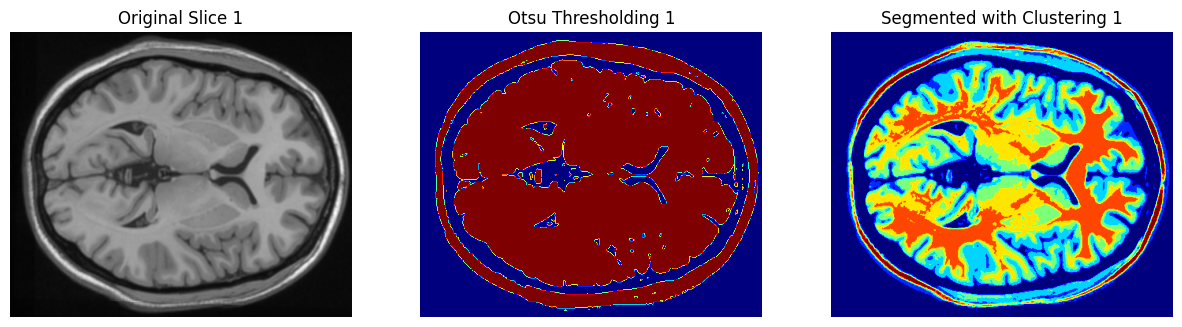

(362, 434)


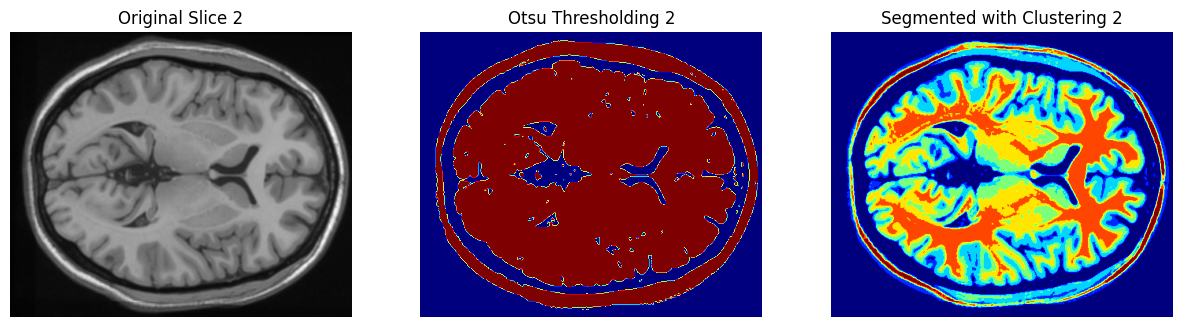

(362, 434)


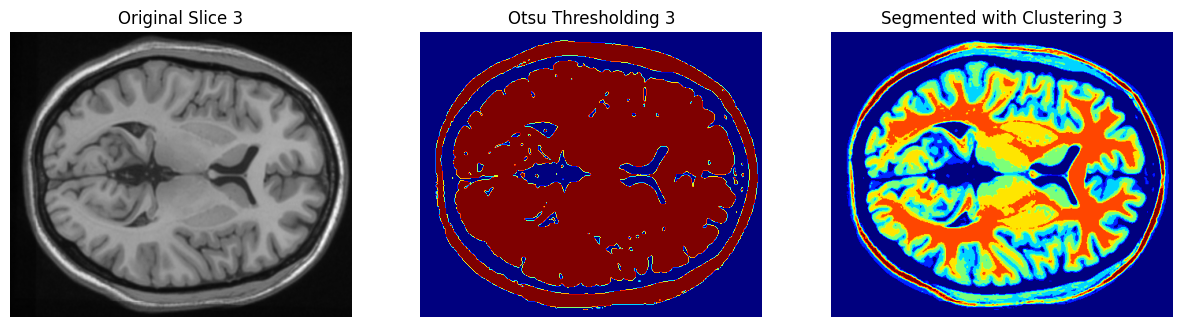

(362, 434)


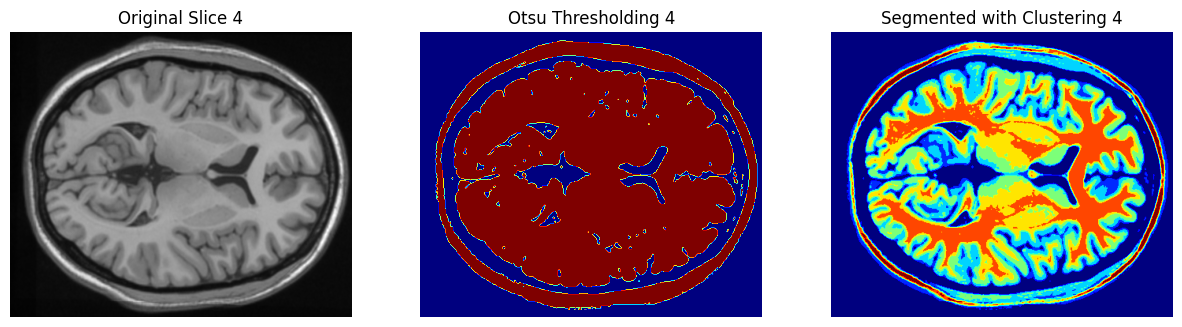

(362, 434)


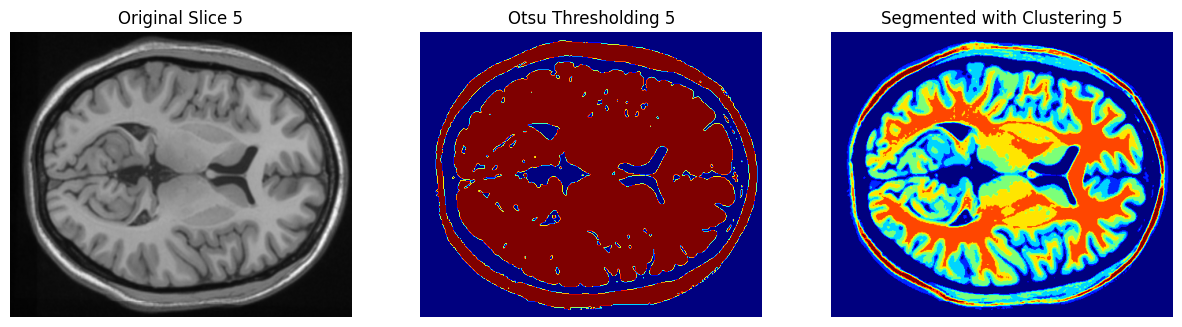

(362, 434)


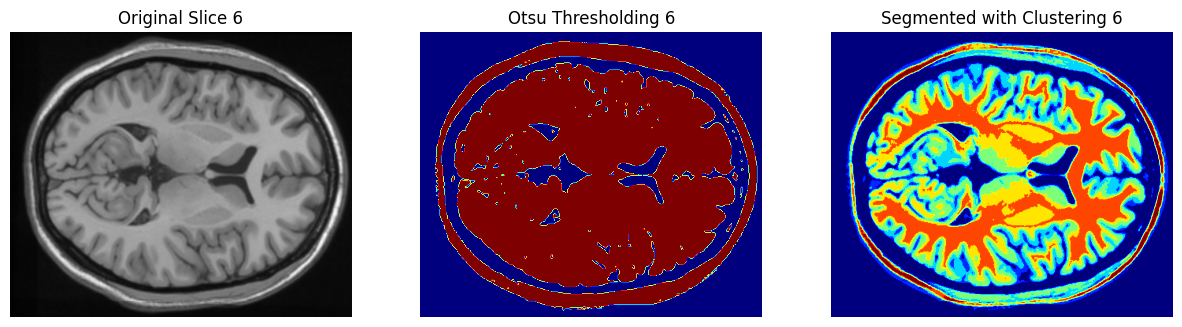

(362, 434)


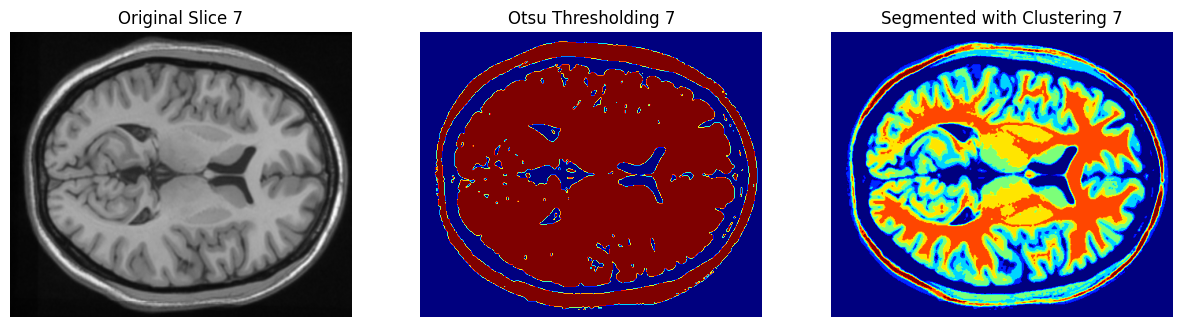

(362, 434)


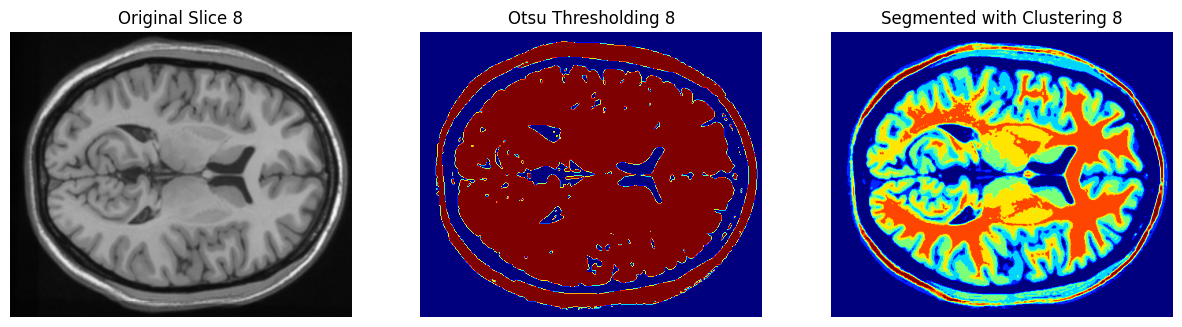

(362, 434)


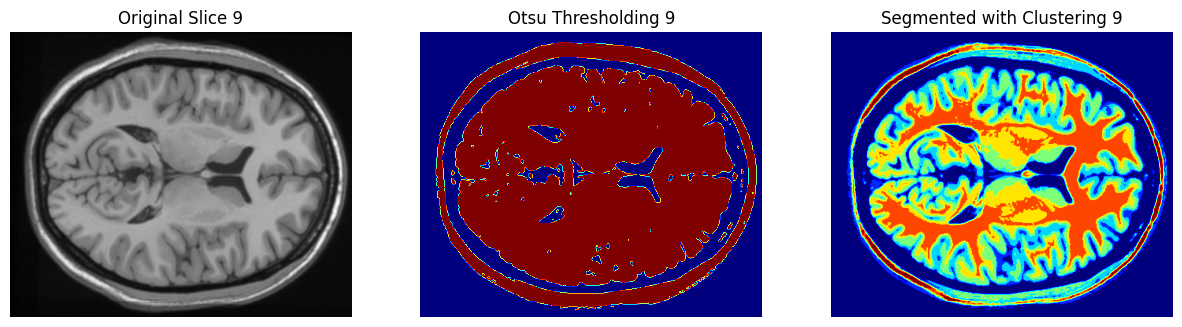

(362, 434)


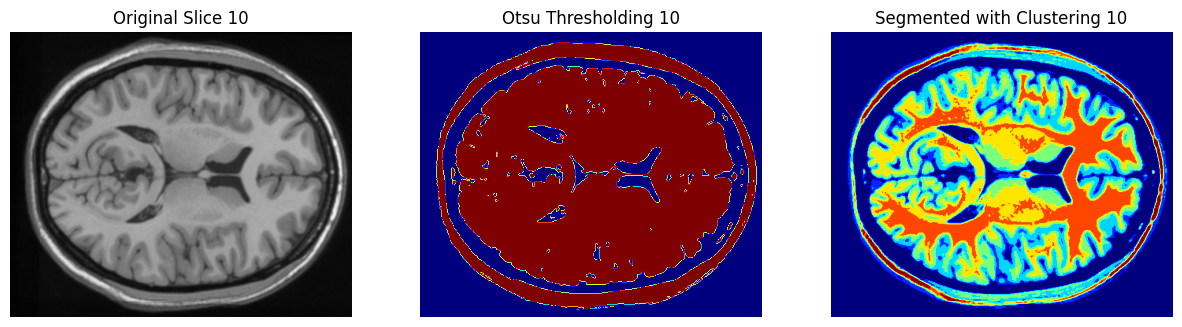

In [26]:
from skimage.filters import threshold_otsu
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.mixture import GaussianMixture as GMM

# Load the .mat file
mat = loadmat('Brain.mat')  # Replace with the correct path to your Brain.mat file
T1 = mat['T1'].astype(np.float32)  # Assuming 'T1' is the key for MRI slices
num_slices = T1.shape[2]

# Define a function to map K-means labels to tissue types
def map_labels_to_tissue_types(kmeans, centroids_order):
    sorted_idx = np.argsort(kmeans.cluster_centers_.flatten())
    mapping = dict(zip(sorted_idx, centroids_order))
    mapped_labels = np.vectorize(mapping.get)(kmeans.labels_)
    return mapped_labels

# Define the order of centroids based on expected tissue brightness
centroids_order = [0, 1, 2, 3, 4, 5]  # Air, Skin, Skull, CSF, Gray Matter, White Matter

for i in range(num_slices):
    slice = T1[:, :, i]
    slice_normalized = (slice - np.min(slice)) / (np.max(slice) - np.min(slice))

    thresh = threshold_otsu(slice_normalized)
    binary_mask = slice_normalized > thresh

    foreground_pixels = slice_normalized[binary_mask].reshape(-1, 1)

    kmeans = KMeans(n_clusters=6, n_init=10, random_state=42)
    kmeans.fit(foreground_pixels)

    # Including spatial context
    X, Y = np.meshgrid(np.arange(slice.shape[1]), np.arange(slice.shape[0]))
    spatial_info = np.stack((X.flatten(), Y.flatten()), axis=-1)

    # Combine intensity and spatial features
    combined_features = np.concatenate((slice_normalized.flatten()[:, np.newaxis], spatial_info), axis=1)

    # Apply GMM for segmentation
    gmm = GMM(n_components=6, random_state=42).fit(combined_features)
    gmm_labels = gmm.predict(combined_features).reshape(slice.shape)

    # Map the K-means cluster labels to tissue types
    mapped_labels = map_labels_to_tissue_types(kmeans, centroids_order)

    segmented_slice = np.zeros_like(slice_normalized)
    segmented_slice[binary_mask] = mapped_labels + 1  # Offset by 1 to differentiate from background

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(slice_normalized, cmap='gray')
    plt.title(f'Original Slice {i+1}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(binary_mask, cmap='jet')
    plt.title(f'Otsu Thresholding {i+1}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(segmented_slice, cmap='jet')
    plt.title(f'Segmented with Clustering {i+1}')
    plt.axis('off')

    plt.show()


# ***K-means and Watershed***

In [27]:
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.io import loadmat

# Load the ground truth images
ground_truth_data = loadmat('Brain.mat')  # Replace with the correct path
ground_truth_segmentation = ground_truth_data['label']

# Placeholder for accumulating segmented slices
segmented_slices_accumulator = []

# Process each slice for segmentation
for i in range(num_slices):
    slice = T1[:, :, i]
    slice_normalized = (slice - np.min(slice)) / (np.max(slice) - np.min(slice))

    # Apply thresholding to create a binary mask
    thresh = threshold_otsu(slice_normalized)
    binary_mask = slice_normalized > thresh

    # Apply KMeans to foreground pixels
    foreground_pixels = slice_normalized[binary_mask].reshape(-1, 1)
    kmeans = KMeans(n_clusters=6, random_state=42).fit(foreground_pixels)

    # Reconstruct the segmented slice from KMeans labels
    segmented_slice = np.zeros_like(slice_normalized)
    segmented_slice[binary_mask] = kmeans.labels_ + 1  # Offset by 1 to avoid using 0 as a label

    segmented_slices_accumulator.append(segmented_slice)

# Stack the segmented slices to form a 3D array
segmented_slices_3d = np.stack(segmented_slices_accumulator, axis=-1)

# Assuming the shapes now match, calculate MSE and accuracy for each slice
mse_values = [mean_squared_error(ground_truth_segmentation[:, :, i].flatten(),
                                 segmented_slices_3d[:, :, i].flatten()) for i in range(num_slices)]

# Calculate the overall MSE and accuracy
overall_mse = np.mean(mse_values)
accuracies = [np.mean(ground_truth_segmentation[:, :, i] == segmented_slices_3d[:, :, i])
              for i in range(num_slices)]
overall_accuracy = np.mean(accuracies)

# Print the MSE values and accuracies
print(f"Mean Squared Errors for each slice: {mse_values}")
print(f"Overall Mean Squared Error: {overall_mse}")
print(f"Accuracies for each slice: {accuracies}")
print(f"Overall Accuracy: {overall_accuracy}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Mean Squared Errors for each slice: [3.678024, 3.8009012, 4.1690364, 4.104839, 4.296891, 4.2365317, 3.3926024, 4.3131475, 4.369701, 4.415065]
Overall Mean Squared Error: 4.07767391204834
Accuracies for each slice: [0.2764976958525346, 0.41095934007179774, 0.39106219925147034, 0.2941034193039183, 0.3138605290628103, 0.40192097156096446, 0.44495506275937574, 0.2956628561244494, 0.31520355424294116, 0.3106079894085597]
Overall Accuracy: 0.3454833617638822


In [16]:
from scipy.io import loadmat

# Load the .mat file
mat_data = loadmat('Brain.mat')

# Check the keys in the loaded .mat file
print(mat_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'T1', 'label'])
